# Lab03: Intermediate Python Programs

**Brief Honor Code**. Do the homework on your own. You may discuss ideas with your classmates, but DO NOT copy the solutions from someone else or the Internet. If stuck, discuss with TA.

**1**. (50 points)

Write separate `toolz` pipelines to generate the following variables

- words: a list of all the words in the files `fortune?.txt` in the `data` directory
- reverse_index: a reverse index of words (key=position, value=word)
- index: an index of words (key=word, value=position)
- cat: a list containing the categorical encoding of words

Finally, use `numpy` to convert `cat` into a one-hot matrix with shape (#words, #unique words)

In [1]:
# Libraries

%matplotlib inline
import matplotlib.pyplot as plt

import glob
import toolz as tz
import toolz.curried as c
import string
import numpy as np

from numba import jit

In [2]:
# Create a list of all words in appropriate files
words = tz.pipe(
    # Glob creates list of all files matching format with ?
    glob.glob("data/fortune?.txt"),
    c.map(open),
    # Class attributes must be converted to a lambda function
    c.map(lambda f: f.readlines()),
    # Make words into one list, lowercase, remove punctuation, etc.
    tz.concat,
    c.map(lambda x: x.lower()),
    c.map(lambda x: x.translate(str.maketrans("", "", string.punctuation))),
    c.mapcat(lambda x: x.split()),
    list
)

In [3]:
# Reverse index: dictionary having key = position, value = word
reverse_index = tz.pipe(
    words,
    # This combination creates list of unique words with index, converts to dictionary
    tz.unique,
    enumerate,
    dict
)

In [4]:
# Index: dictionary having key = word, value = position
index = tz.pipe(
    # Get key-values from last step and reverse their positions
    reverse_index.items(),
    c.map(lambda x: (x[1], x[0])),
    dict
)

In [5]:
# Cat: generate list of the first appearance of each word in the data
cat = tz.pipe(
    words,
    c.map(lambda x: index[x]),
    list
)

In [6]:
# Generate m, a one-hot matrix with shape (#words, #unique words)
n = len(words)
u = len(index)
m = np.zeros((n, u), dtype = "int")
# Vectorized assignment:
    # Each row comes from range(n), so each row has a value
    # The column value corresponds to the index from cat, the list of first indexes
m[range(n), cat] = 1

**2**. (50 points)

Write a simulation of diffusion-limited aggregation. In this simulation, we have $n$ random walkers. Each walker starts from row 0 and a random column number, and in each step, the walker increases the row number by 1 and randomly increments or decrements its column number by 1. If the column number of the walker exceeds the maximum or becomes negative, the walker emerges on the other side (toroidal boundary conditions). At any time, if any of the walkers 8 neighbors is non-zero, the walker stops in that position, and the number of steps taken is recorded in that (row, column).

Write a function `dla(nwalkers, width, height, seed)` that returns a matrix with shape (width, height) after running `nwalkers` random walks as described above. The argument `ssed` is used to initialize a random number seed. Internally, the function should create a (width, height+1) matrix, and initialize the last row to have 1 with all other entries 0.

Feel free to use loops. This function is not easily vectorized.

Plot the returned matrix for the arguments `nwalkers=10000, width=300, height=150, seed=123`. It should look like this:

![dla](figs/dla.png)

In [7]:
# Explanation:
    # Note that we simulate this by letting walkers run in sequence instead of all at once
    # Then it becomes quite simple, b/c you can just let one go and check for neighbors at each step

In [8]:
#  dla function
def dla(nwalkers, width, height, seed = 123):
    
    # Set seed
    np.random.seed(seed)
    
    # Nice convention: change desciptive function inputs to simpler implementation variables
    w = width
    h = height
    xs = np.zeros((h+1, w), dtype=np.int32)
    # Initialize last row
    xs[h,:] = h
    
    for walker in range(nwalkers):
        # Randomize initial column
        j = np.random.randint(0, w)
        
        # Progress walker upwards
        for i in range(h):
            # Randomly move walker left/right
            j += np.random.choice(np.array([-1, 1]))
            
            # Loop back if out of bounds
            j %= (w-1)
            
            # Check for neighbors, break if necessary
            if np.sum(xs[i-1:i+2, j-1:j+2]) > 0:
                xs[i,j] = i
                break
                
    # Return array
    return xs[:-1, :]

In [9]:
%%time
# Run simulation and find its runtime
xs = dla(10000, 300, 150)

Wall time: 17.3 s


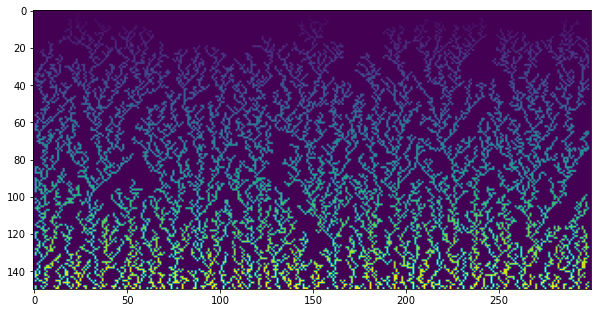

In [10]:
# Plot simulation
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(xs);

In [11]:
# Use JIT compilation to compare performance
dla_jit = jit(dla, nopython=True)

In [12]:
%%time
# Run JIT compiled function and find its runetime
ys = dla_jit(10000, 300, 150)

Wall time: 902 ms


In [13]:
# Check whether results are the same
np.all(xs == ys)

True

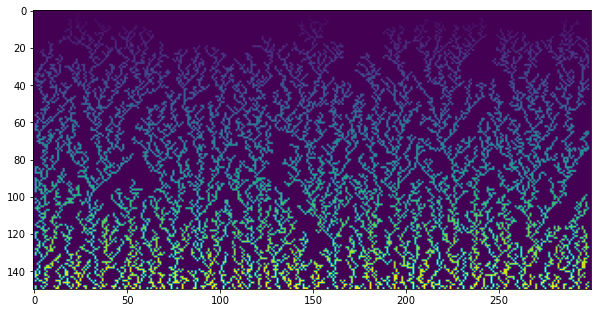

In [14]:
# Verify that JIT compilation returns the same graph
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(ys);